# 1. 音響学

## 純音・複合音

サイン波は純音である。$a$は振幅、$f$は周波数、$\theta$は位相を表す。振幅は音の大きさ、周波数は音の高さに対応する。
$$
s(t) = a \sin (2\pi ft + \theta)
$$

あらゆる波形はサイン波の寄せ集めである。複数のサイン波によって構成される波形の音を複合音と呼び、次のように定義できる。

$$
s(t) = \sum_i a_i \sin(2\pi f_i t + \theta_i)
$$

In [1]:
DATADIR = '../datasets/'

In [2]:
from dataclasses import dataclass
from typing import Optional, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile

In [3]:
@dataclass
class SineWave:
    f: float
    a: float = 1.
    theta: float = 0.

    def s(self, t: np.ndarray) -> np.ndarray:
        return self.a * np.sin(2 * np.pi * self.f * t + self.theta)

@dataclass
class CompositeWave:
    waves: list[SineWave]

    def s(self, t: np.ndarray) -> np.ndarray:
        return np.sum([wave.s(t) for wave in self.waves], axis=0)

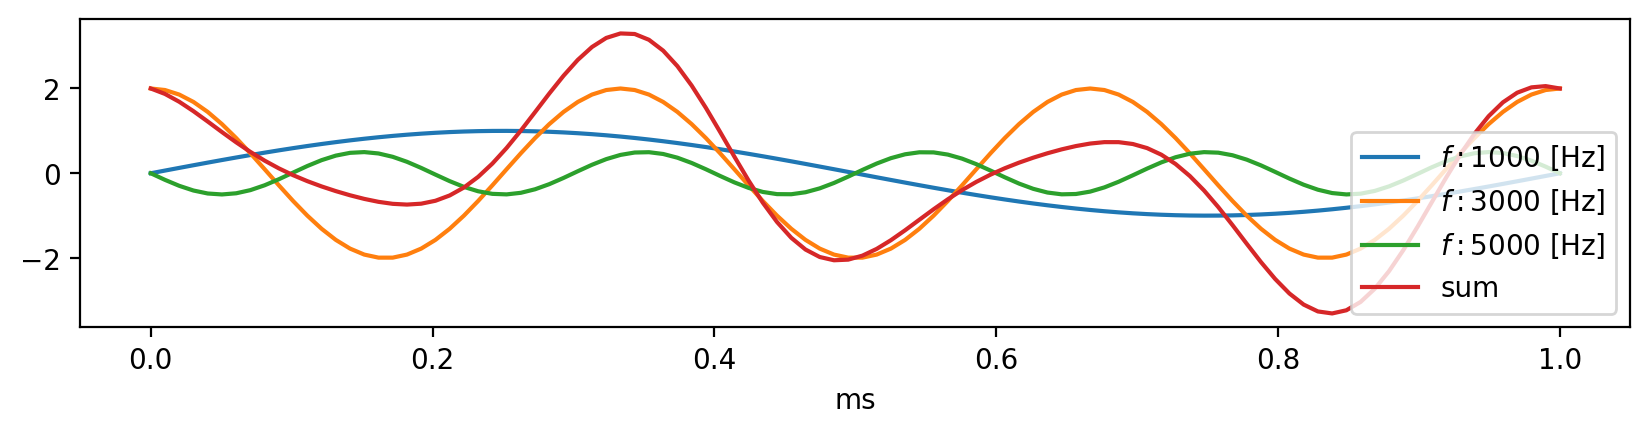

In [4]:
t = np.linspace(0., 0.001, 100)  # sec
t_ms = t * 1000.0  # msec

waves = [
    SineWave(f=1000, a=1),
    SineWave(f=3000, a=2, theta=np.pi / 2),
    SineWave(f=5000, a=0.5, theta=np.pi)
]

plt.figure(figsize=(10, 2), dpi=200)
for wave in waves:
    plt.plot(t_ms, wave.s(t), label=f'$f: {wave.f}$ [Hz]')

plt.plot(t_ms, CompositeWave(waves).s(t), label='sum')
plt.xlabel('ms')
plt.legend()
plt.show()

# 2. サウンドプログラミング

In [5]:
# 一般的なサンプリングレート 44.1kHz
RATE = 44100

In [6]:
# 0 ~ 1の範囲に信号を収める
def _normalize(s):
    return (s - np.min(s)) / (np.max(s) - np.min(s))

# 0.5足して整数部分を抽出 = 5切り上げの四捨五入
def _round(s):
    return (s + 0.5).astype(int)

# 量子化（16ビット）
def digitalize_16bit(s):
    s = _normalize(s) * 2 ** 16
    s = _round(s)
    s = np.clip(s, 0, 2 ** 16 - 1)  # クリッピング
    s -= 2 ** 15
    return s.astype('int16')

# フェード処理
def add_fade(s, n_pre=400, n_post=400):
    s_ = s.copy()
    s_[:n_pre] *= np.arange(n_pre) / n_pre
    s_[-n_post:] *= np.arange(n_post)[::-1] / n_post
    return s_

# オフセット処理（無音区間の追加）
def add_offset(s, n_pre=400, n_post=400):
    s_ = np.append(np.zeros(n_pre), s)
    s_ = np.append(s_, np.zeros(n_post))
    return s_

純音（1000Hz）の生成

In [7]:
duration = 1  # sec
t = np.linspace(0, duration, RATE * duration)
n_offset = int(RATE * 0.01)  # フェード処理・オフセット処理を施すサンプル数

wave = SineWave(f=1000, a=0.1)
s = wave.s(t)
s = add_fade(s, n_pre=n_offset, n_post=n_offset)
s = add_offset(s, n_pre=n_offset, n_post=n_offset)
s = digitalize_16bit(s)

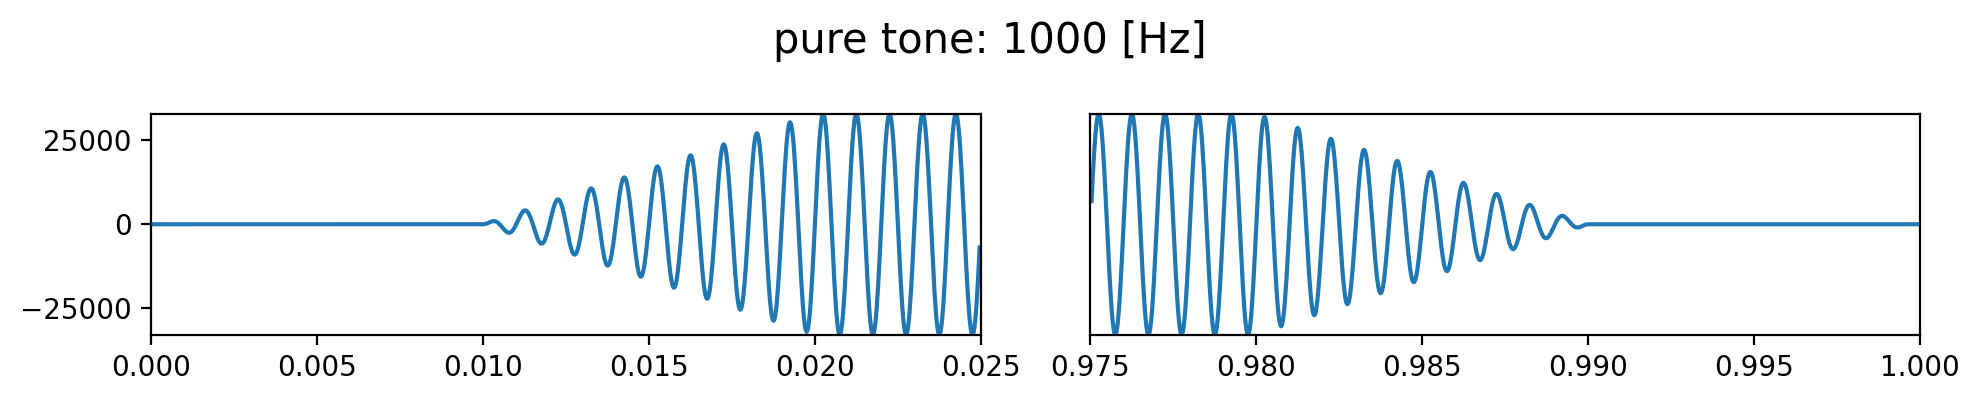

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2), dpi=200)

# フェード処理・オフセット処理を確認するために先頭と末尾を描画
t_head, t_tail = 0.025, 0.025  # sec
n_head, n_tail = int(RATE * t_head), int(RATE * t_tail)

# 先頭
ax1.plot(t[:n_head], s[:n_head])
ax1.set_xlim(0, t_head)
ax1.set_ylim(np.iinfo(np.int16).min, np.iinfo(np.int16).max) # 量子化された信号が16-bitの範囲内にあることを確認

# 末尾
ax2.plot(t[-n_tail:], s[-n_tail:])
ax2.set_xlim(1 - t_tail, 1)
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks([])

plt.suptitle(f'pure tone: {wave.f} [Hz]', fontsize=15)
plt.tight_layout()
plt.show()

In [9]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.write.html
filename = f'ch2_{wave.f}Hz.wav'
wavfile.write(DATADIR + filename, RATE, s)

# 3. コンピュータミュージック

## 12平均律音階の実装
- 五線譜のそれぞれの線が表す音の高さは音階と呼ばれるルールに従って定義
- 音階として最も代表的なのが12平均律音階。
    - 音名を表すアルファベット A, B, C, D, E, F, G（ラシドレミファソ）
    - シャープ ♯ フラット ♭

- 参考
    - https://www.aihara.co.jp/~taiji/browser-security/js/equal_temperament.html
    - https://www.asahi-net.or.jp/~hb9t-ktd/music/Japan/Research/DTM/freq_map.html

In [10]:
def create_scale(n=88, base=440., base_idx=48, start_note='A', start_octave=0):
    NAMES = ("C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B")
    scale = {}

    for idx in range(n):
        idx_ = idx + NAMES.index(start_note)
        name = NAMES[idx_ % 12]
        octave = idx_ // 12 + start_octave
        scale[name + str(octave)] = base * 2 ** ((idx - base_idx) / 12)
        
    return scale

In [11]:
scale_88 = create_scale()  # default: Piano 88 keys
scale_128 = create_scale(n=128, base_idx=69, start_note='C', start_octave=-1)  # MIDI keys

df_88 = pd.DataFrame.from_dict(scale_88, orient='index', columns=['Hz'])
df_128 = pd.DataFrame.from_dict(scale_128, orient='index', columns=['Hz'])

display(df_88)
display(df_128)

,Hz
A0,27.500000
A#0,29.135235
B0,30.867706
C1,32.703196
C#1,34.647829
...,...
G#7,3322.437581
A7,3520.000000
A#7,3729.310092
B7,3951.066410


,Hz
C-1,8.175799
C#-1,8.661957
D-1,9.177024
D#-1,9.722718
E-1,10.300861
...,...
D#9,9956.063479
E9,10548.081821
F9,11175.303406
F#9,11839.821527


## 和音

In [12]:
duration = 1
t = np.linspace(0, duration, RATE * duration)
notes = ('F5', 'A5', 'C6')

s = CompositeWave([SineWave(f=scale_88[note]) for note in notes]).s(t)
s = add_fade(s)
s = add_offset(s)
s = digitalize_16bit(s)

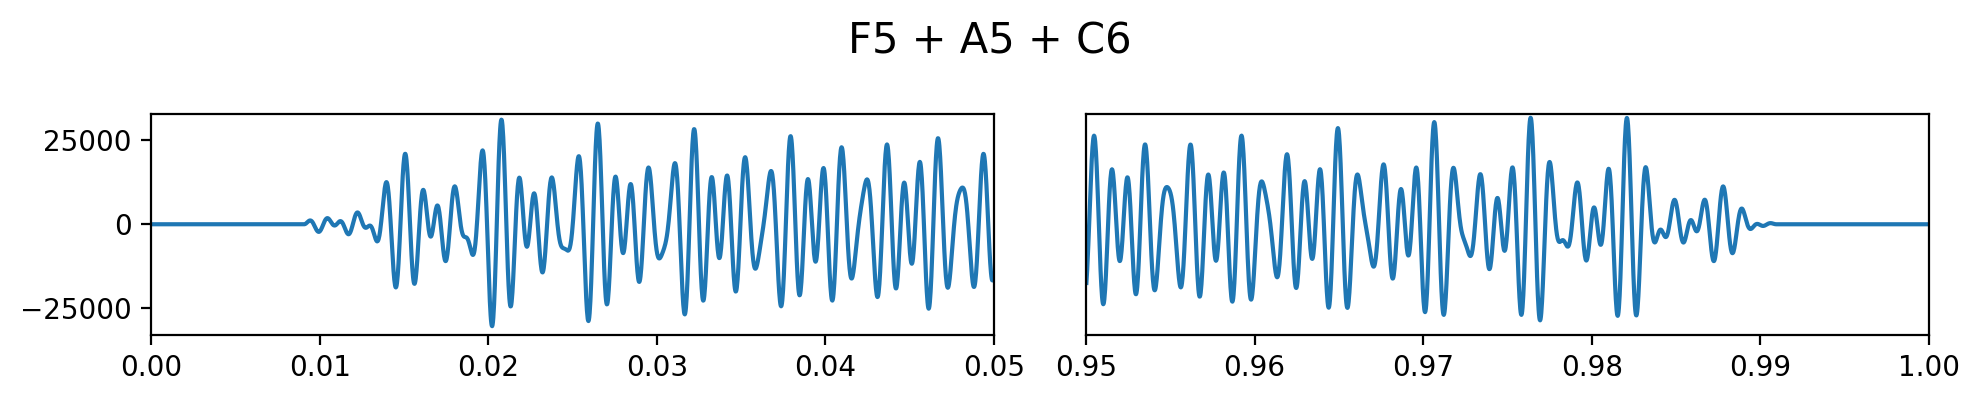

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2), dpi=200)

t_head, t_tail = 0.05, 0.05  # sec
n_head, n_tail = int(RATE * t_head), int(RATE * t_tail)

ax1.plot(t[:n_head], s[:n_head])
ax1.set_xlim(0, t_head)
ax1.set_ylim(np.iinfo(np.int16).min, np.iinfo(np.int16).max)

ax2.plot(t[-n_tail:], s[-n_tail:])
ax2.set_xlim(1 - t_tail, 1)
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks([])

plt.suptitle(' + '.join(notes), fontsize=15)
plt.tight_layout()
plt.show()

In [14]:
filename = 'ch3_' + ''.join(notes) + '.wav'
wavfile.write(DATADIR + filename, RATE, s)

## トラック

In [15]:
@dataclass
class Note:
    start: float  # sec
    pitch: str
    gain: float = 0.5
    duration: float = 1.  # sec

@dataclass
class Track:
    scale: dict[str, float]
    notes: list[Note]

    def generate(self, duration, offset=0, rate=RATE):
        t = np.linspace(0, duration, int(rate * duration))
        s = np.zeros_like(t)

        for note in self.notes:
            idx_start = int((note.start + offset) * rate)
            idx_end = int((note.start + note.duration + offset) * rate)
            s[idx_start:idx_end] += SineWave(f=self.scale[note.pitch], a=note.gain).s(t[idx_start:idx_end])
        return t, s

In [16]:
tempo = 120
duration = 20 * (60 / tempo) + 2

track1 = Track(
    scale=scale_88,
    notes=[
        Note(2, 'E5', 0.8),
        Note(3, 'D5', 0.8),
        Note(4, 'C5', 0.8),
        Note(5, 'B4', 0.8),
        Note(6, 'A4', 0.8),
        Note(7, 'G4', 0.8),
        Note(8, 'A4', 0.8),
        Note(9, 'B4', 0.8)
    ]
)

track2 = Track(
    scale=scale_88,
    notes=[
        Note(2, 'C4', 0.4),
        Note(3, 'G3', 0.4),
        Note(4, 'A3', 0.4),
        Note(5, 'E3', 0.4),
        Note(6, 'F3', 0.4),
        Note(7, 'C3', 0.4),
        Note(8, 'F3', 0.4),
        Note(9, 'G3', 0.4),
    ]
)

t, s1 = track1.generate(duration)
t, s2 = track2.generate(duration)
s = s1 + s2

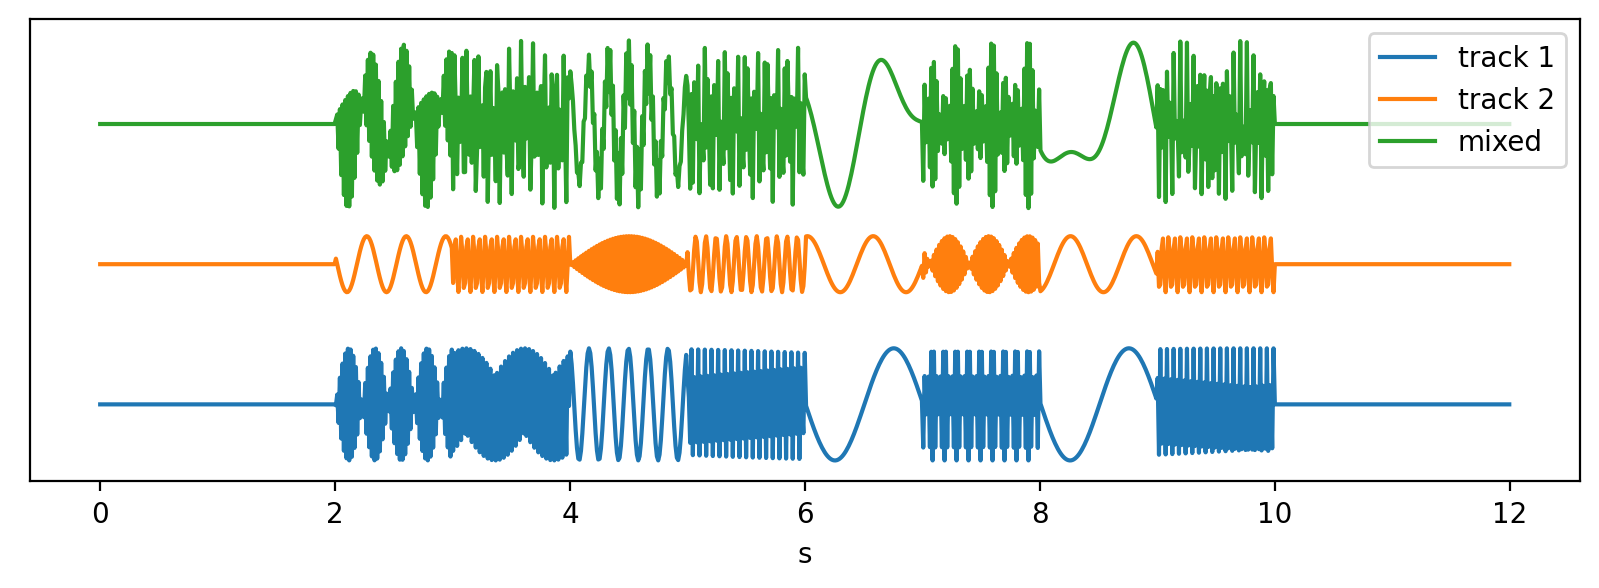

In [17]:
offset = 2
step = 500

plt.figure(figsize=(10, 3), dpi=200)

plt.plot(t[::step], s1[::step], label='track 1')
plt.plot(t[::step], s2[::step] + offset, label='track 2')
plt.plot(t[::step], s[::step] + offset * 2, label='mixed')

plt.xlabel('s')
plt.yticks([])

plt.legend()
plt.show()

In [18]:
s /= np.max(np.abs(s))
master_volume = 0.5
s *= master_volume
s = digitalize_16bit(s)

In [19]:
filename = 'ch3_canon.wav'
wavfile.write(DATADIR + filename, RATE, s)